## I share the know-how to speed up training.

## Archtecture
<!-- This is a overview of model.  
![model](https://github.com/motono0223/kaggle_public/blob/main/2022_guie/GUIE_Model.png?raw=true)   -->

Training the entire model takes a long time because the backbone model is very large.  
In this notebook, I propose to split model into a backbone model and a projection model like following steps.

## Steps
- Step1: infers the backbone model to get training data.  
<!-- ![backbonemobel](https://github.com/motono0223/kaggle_public/blob/main/2022_guie/GUIE_BackboneModel.png?raw=true) -->

- Step2: trains the projection model with output of step1.  
<!-- ![projectionmodel](https://github.com/motono0223/kaggle_public/blob/main/2022_guie/GUIE_ProjectionModel.png?raw=true) -->

- Step3: save weights of entire "model".  
In this notebook, the entire "model" shares the same weights with backbone model and projection model.

<!-- ## Note
If you want to use the data augment method for training model, please consider to add the process of training "model" above as finetuning. -->

# Train in Colan enviroment 


In [1]:
# !pip install git+https://github.com/innat/transformers -U -q > /dev/null
import os
def is_colab_env():
    is_colab = False
    for k in os.environ.keys():
        if "COLAB" in k:
            is_colab = True
            break
    return is_colab
    
if is_colab_env():
    !pip install transformers
    !pip install tensorflow_addons
from transformers import CLIPProcessor, TFCLIPVisionModel, CLIPFeatureExtractor

# from kaggle_datasets import KaggleDatasets

import re
import os
import glob
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from tensorflow.keras import backend as K

import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
import gc
from zipfile import ZipFile
from PIL import Image
import requests

from mpl_toolkits import axes_grid1





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Make sure to use the TPU of Colab


In [2]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.55.240.34:8470
REPLICAS:  8


# Set the contant config value

In [3]:
class config:
    VERSION = 60

    SEED = 42
    RESUME = False
    RESUME_EPOCH = 0
    RESUME_WEIGHT = ""

    model_type = "clip-vit-large-patch14"
    EFF_SIZE = 0
    EFF2_TYPE = ""
    # 336/224
    IMAGE_SIZE = 224
    BATCH_SIZE_INFER = 16 * strategy.num_replicas_in_sync
    BATCH_SIZE_TRAIN = 100 * strategy.num_replicas_in_sync
    N_CLASSES = 9691
    EMB_DIM = 64
    EPOCHS = 100
    LR = 0.0012

    save_dir = "./"

    TRAIN = True
    
    DEBUG = False
    
    TTA = 1


# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
seed_everything(config.SEED)

MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_SIZE}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF2_TYPE}'
elif "swin" in config.model_type:
    MODEL_NAME = config.model_type
elif "conv" in config.model_type:
    MODEL_NAME = config.model_type
else:
    MODEL_NAME = config.model_type

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

clip-vit-large-patch14


# The root path of our datasets in Google cloud

In [4]:
dict_target_dataset = {
    # base
        # "guie-imagenet1k-mini1-tfrecords-label-0-999" : "gs://wenxuanye/imagenet1k",
        "guie-products10k-tfrecords-label-1000-10690" : "gs://wenxuanye/products10k",
        "guie-glr2021mini-tfrecords-label-10691-17690" : "gs://wenxuanye/google_landmark",
        "omnibench-label-17691":"gs://wenxuanye/omnibenchmark",
        # "deepfashion":"gs://wenxuanye/deepfashion"



}

PREPROC_DATASET_DIR = f"./preproc/"

# Read the tfrecord datasets for classification


In [5]:
def deserialization_fn(serialized_example):
    parsed_example = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        }
    )
    image = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, size=(config.IMAGE_SIZE, config.IMAGE_SIZE))
    label = tf.cast(parsed_example['image/class/label'], tf.int64)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
def arcface_format(image, label_group):
    return {'inp1': image, 'inp2': label_group}, label_group

def rescale_image(image, label_group):
    image = tf.cast(image, tf.float32) * 255.0
    return image, label_group

# Data augmentation function
def data_augment(image, label_group):
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)

    return image, label_group

# Dataset to obtain backbone's inference
# output : ( image, label ), (label) 
def get_backbone_inference_dataset(tfrecord_paths, cache=False, repeat=False, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_paths)
    dataset = dataset.shuffle(len(tfrecord_paths)) if shuffle else dataset
    dataset = dataset.flat_map(tf.data.TFRecordDataset)
    dataset = dataset.map(deserialization_fn, num_parallel_calls=AUTO) # image[0-1], label[0-999]

    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)  # (image, label_group) --> (image, label_group)
    dataset = dataset.map(rescale_image, num_parallel_calls = AUTO)  # image[0-1], label[0-n_classes] --> image[0-255], label[0-n_classes]
    dataset = dataset.map(arcface_format, num_parallel_calls=AUTO)   # (image, label_group) --> ({"inp1":image, "inp2":label_group}, label_group )
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(config.BATCH_SIZE_INFER)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Model

## Distance Margin Layer
This notebook uses distance margin layer instead of the ArcFace Layer.  
  
With ArcFace, the embedding vectors are distributed over the surface of an N-dimensional sphere.   
This is because ArcFaceLayer outputs the inner product of its own weight matrix and embedding vector to the next Softmax layer.   
Although this embedding vector is easy to work with, it is not a very efficient use of the embedding vector space.  

So I introduce a distance margin layer.   
This outputs the inverse squared Euclidean distance in the next Softmax layer, not the inner product.  
![DistanceMarginLayer](https://github.com/motono0223/kaggle_public/blob/main/2022_guie/GUIE_DistanceLayer.png?raw=true)

In [6]:
class DistanceMarginLayer(tf.keras.layers.Layer):
    def __init__(self, n_classes, s=30, m=0.10, easy_margin=False,
                 ls_eps=0.0, sgm=1.0, **kwargs):

        super(DistanceMarginLayer, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.sgm = sgm

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(DistanceMarginLayer, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        
        W2 = self.W 

        X2 = tf.tile(tf.expand_dims(X, 2), [1, 1, self.W.shape[1] ])  # X.shape=[Batch, EmbDim], X2.shape=[Batch, EmbDim, NumClass]

        # distance on the N-Dimentional coordinate
        dx = tf.math.sqrt( tf.reduce_sum( tf.math.pow( X2 - W2, 2 ), axis=1) ) # dx.shape=[Batch, NumClass]

        dx = tf.clip_by_value( dx    , 0.00001, 50.0)
        output1 = self.s / tf.math.pow( dx, 2 )
        output2 = self.s / tf.math.pow( dx, 2 ) + self.m

        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=dx.dtype
        )

        output = (one_hot * output1) + ((1.0 - one_hot) * output2)

        return output

# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output
        

In [7]:
def get_scale_layer(rescale_mode = "tf"):
    # For keras_cv_attention_models module:
    # ref: https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/imagenet/data.py
    # ref function : init_mean_std_by_rescale_mode()

    # For effV2 (21k classes) : https://github.com/leondgarse/keras_efficientnet_v2

    if isinstance(rescale_mode, (list, tuple)):  # Specific mean and std
        mean, std = rescale_mode
    elif rescale_mode == "torch":
        mean = np.array([0.485, 0.456, 0.406]) * 255.0
        std = np.array([0.229, 0.224, 0.225]) * 255.0
    elif rescale_mode == "tf":  # [0, 255] -> [-1, 1]
        mean, std = 127.5, 127.5
    elif rescale_mode == "tf128":  # [0, 255] -> [-1, 1]
        mean, std = 128.0, 128.0
    elif rescale_mode == "raw01":
        mean, std = 0, 255.0  # [0, 255] -> [0, 1]
    else:
        mean, std = 0, 1  # raw inputs [0, 255]        
    scaling_layer = keras.layers.Lambda(lambda x: ( tf.cast(x, tf.float32) - mean) / std )
    
    return scaling_layer

def get_clip_model():
    inp = tf.keras.layers.Input(shape = [3, config.IMAGE_SIZE, config.IMAGE_SIZE])
#    backbone = TFCLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
# openai/clip-vit-large-patch14-336
# openai/clip-vit-large-patch14
    backbone = TFCLIPVisionModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K",from_pt = True)
    output = backbone({'pixel_values':inp}).pooler_output
    return tf.keras.Model(inputs=[inp], outputs=[output])


In [8]:

def get_embedding_model_new(frozen=True):
    #------------------
    # Definition of placeholders
    inp = tf.keras.layers.Input(shape = [None, None, 3], name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')

    # Definition of layers
    layer_resize = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [config.IMAGE_SIZE, config.IMAGE_SIZE]), name='resize')
    layer_scaling = get_scale_layer(rescale_mode = "torch")
    layer_permute = tf.keras.layers.Permute((3,1,2))
    layer_backbone = get_clip_model()
    if frozen:
        layer_backbone.trainable = False
    # layer_pool = tf.keras.layers.GlobalAveragePooling1D(1024)
    # add 1d batch norm
    layer_batch_norm = tf.keras.layers.BatchNormalization()
    # add prreLU
    layer_prelu = tf.keras.layers.PReLU()
    layer_dropout = tf.keras.layers.Dropout(0.2)
    layer_dense_before_arcface = tf.keras.layers.Dense(256)
    layer_margin = DistanceMarginLayer(
        n_classes = config.N_CLASSES, 
        s = 30, 
        m = 0.3,  # no margin in this notebook
        name=f'head/distancemargin', 
        dtype='float32'
        )
    # layer_margin = ArcMarginProduct(
    #     n_classes = config.N_CLASSES, 
    #     s = 30, 
    #     m = 0.3, 
    #     name=f'head/arcface', 
    #     dtype='float32'
    #     )


    layer_softmax = tf.keras.layers.Softmax(dtype='float32')
    layer_adaptive_pooling = tfa.layers.AdaptiveAveragePooling1D(64)
    layer_norm = tf.keras.layers.Lambda(lambda x: x, name='embedding_norm')
    #------------------
    # Definition of entire model 
    image = layer_scaling(inp)
    image = layer_resize(image)
    image = layer_permute(image)
    backbone_output = layer_backbone(image)
    # embed = layer_pool(backbone_output)
    embed = layer_dropout(backbone_output)
    embed = layer_batch_norm(embed)
    embed = layer_prelu(embed)
    
    embed = layer_dense_before_arcface(embed)
    x = layer_margin([embed, label])
    output = layer_softmax(x)
    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output]) # whole architecture

    #------------------
    # Definition of embedding model (for submission)
    x = layer_adaptive_pooling(embed)
    emboutput = layer_norm(x)
    embed_model = tf.keras.models.Model(inputs = [inp, label], outputs = [emboutput]) # whole architecture
    
    #------------------
    # Definition of backbone model (to obtain training data)
    backbone_model = tf.keras.models.Model(inputs = [inp, label], outputs = [backbone_output, label])  

    #------------------
    # Definition of projection Model (to train projection layers)
    # print(backbone_output.shape)
    inp_proj = tf.keras.layers.Input(shape = [backbone_output.shape[-1]], name = 'inp_proj')
    x = layer_dropout(inp_proj)
    x = layer_batch_norm(x)
    x = layer_prelu(x)
    x = layer_dense_before_arcface(x)
    x = layer_margin([x, label])
    output = layer_softmax(x)
    projection_model = tf.keras.models.Model(inputs = [inp_proj, label], outputs = [output])

    # Note: These 4 models share the same weights each other.
    return model, embed_model, backbone_model, projection_model

In [9]:
with strategy.scope():
    model, emb_model, backbone_model, projection_model = get_embedding_model_new()

    opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
    projection_model.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
        )

    if config.RESUME:
        print(f"load {config.RESUME_WEIGHT}")
        model.load_weights( config.RESUME_WEIGHT )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPVisionModel: ['text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.8.layer_norm2.weight', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.1.layer_norm1.weight', 'text_model.encoder.layers.21.self_attn.v_proj.bias', 'text_model.encoder.layers.21.layer_norm1.bias', 'text_model.encoder.layers.7.mlp.fc1.bias', 'text_model.encoder.layers.15.self_attn.v_proj.bias', 'text_model.encoder.layers.10.self_attn.out_proj.weight', 'text_model.encoder.layers.13.layer_norm2.bias', 'text_model.encoder.layers.19.layer_norm2.bias', 'text_model.encoder.layers.4.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.10.layer_norm1.weight', 'text_model.encoder.layers.15.layer_norm2.bias', 'text_model.encoder.layers.18.self_attn.k_proj.bias', 'text_model.encoder.layers.16.self_attn.v_proj.weight', 'text_model.encoder.layers.17.mlp.fc2.w

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda (Lambda)                (None, None, None,   0           ['inp1[0][0]']                   
                                3)                                                                
                                                                                                  
 resize (Lambda)                (None, 224, 224, 3)  0           ['lambda[0][0]']                 
                                                                                            

In [11]:
emb_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda (Lambda)                (None, None, None,   0           ['inp1[0][0]']                   
                                3)                                                                
                                                                                                  
 resize (Lambda)                (None, 224, 224, 3)  0           ['lambda[0][0]']                 
                                                                                            

In [12]:
backbone_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda (Lambda)                (None, None, None,   0           ['inp1[0][0]']                   
                                3)                                                                
                                                                                                  
 resize (Lambda)                (None, 224, 224, 3)  0           ['lambda[0][0]']                 
                                                                                            

In [13]:
projection_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp_proj (InputLayer)          [(None, 1280)]       0           []                               
                                                                                                  
 dropout_32 (Dropout)           (None, 1280)         0           ['inp_proj[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1280)        5120        ['dropout_32[1][0]']             
 alization)                                                                                       
                                                                                                  
 p_re_lu (PReLU)                (None, 1280)         1280        ['batch_normalization[1][0]

# Step1) Inference of backbone model

In [14]:
def get_num_of_image(file):
    return int(file.split("/")[-1].split(".")[0].split("-")[-1])



In [15]:
train_shard_suffix1 = '*.tfrec'
train_shard_suffix2 = '*/*.tfrec'

list_preproc_files_embeddings_train = []
list_preproc_files_labels_train = []
list_preproc_files_embeddings_valid = []
list_preproc_files_labels_valid = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=config.SEED)

previous_last_label = -1
for (dataset_name, dataset_header) in dict_target_dataset.items():
    GCS_DS_PATH = dict_target_dataset[ dataset_name ]

    print( "// ---------------------------------------" )
    print( f"\"{dataset_name}\" : \"{GCS_DS_PATH}\"," )
    files1 = sorted(tf.io.gfile.glob(GCS_DS_PATH + f'/{train_shard_suffix1}'))
    files2 = sorted(tf.io.gfile.glob(GCS_DS_PATH + f'/{train_shard_suffix2}'))
    files = sorted(files1 + files2)
    data_len = sum( [ get_num_of_image(file) for file in files ] )
    print(files)
    print(dataset_name, ", number of tfrecords = ", len(files), "data length = ", data_len)

    ds = get_backbone_inference_dataset(files,repeat = True)
    # print(ds)
    steps = data_len // config.BATCH_SIZE_INFER
    if data_len % config.BATCH_SIZE_INFER != 0:
        steps += 1
    backbone_output_array, label_array = backbone_model.predict( ds, verbose = 1, steps=steps)

    # relabeling
    label_array = label_array.astype(np.int64)
    min_label = label_array.min()
    max_label = label_array.max()
    start_label = previous_last_label+1
    end_label = previous_last_label+1+max_label-min_label

    label_array = label_array - min_label + previous_last_label+1

    # split data
    for train_index, valid_index in skf.split(range(label_array.shape[0]), label_array):
       X_train, X_valid = backbone_output_array[train_index], backbone_output_array[valid_index]
       y_train, y_valid = label_array[train_index], label_array[valid_index]    
       break
    # X_train, X_valid = backbone_output_array, backbone_output_array
    # y_train, y_valid = label_array, label_array
        
    # save npy files
    list_preproc_files_embeddings_train.append( f"{PREPROC_DATASET_DIR}/_label{start_label}_{end_label}_train_embeddings.npy" )
    list_preproc_files_labels_train.append( f"{PREPROC_DATASET_DIR}/_label{start_label}_{end_label}_train_labels.npy" )
    np.save( list_preproc_files_embeddings_train[-1], X_train)
    np.save( list_preproc_files_labels_train[-1], y_train.astype(np.int64))

    list_preproc_files_embeddings_valid.append( f"{PREPROC_DATASET_DIR}/_label{start_label}_{end_label}_valid_embeddings.npy" )
    list_preproc_files_labels_valid.append( f"{PREPROC_DATASET_DIR}/_label{start_label}_{end_label}_valid_labels.npy" )
    np.save( list_preproc_files_embeddings_valid[-1], X_valid)
    np.save( list_preproc_files_labels_valid[-1], y_valid.astype(np.int64))

    # update previous_last_label
    previous_last_label = end_label

print(f"total_label =", previous_last_label + 1)

if config.N_CLASSES != previous_last_label + 1:
    config.N_CLASSES = previous_last_label + 1
    print( "!!! re-define model !!!" )
    del model
    del emb_model
    del backbone_model
    del projection_model
    gc.collect()
    with strategy.scope():
        model, emb_model, backbone_model, projection_model= get_embedding_model_new()

        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        projection_model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            )

        if config.RESUME:
            print(f"load {config.RESUME_WEIGHT}")
            model.load_weights( config.RESUME_WEIGHT )

// ---------------------------------------
"guie-products10k-tfrecords-label-1000-10690" : "gs://wenxuanye/products10k",
['gs://wenxuanye/products10k/guie-products10k-train-00-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-01-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-02-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-03-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-04-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-05-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-06-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-07-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-08-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-09-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-10-7097.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-11-7096.tfrec', 'gs://wenxuanye/products10k/guie-products10k-train-12-7096.tfrec', 'gs://w

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


// ---------------------------------------
"guie-glr2021mini-tfrecords-label-10691-17690" : "gs://wenxuanye/google_landmark",
['gs://wenxuanye/google_landmark/guie-glr2021-train-00-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-01-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-02-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-03-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-04-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-05-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-06-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-07-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-08-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-09-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-10-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-11-10909.tfrec', 'gs://wenxuanye/google_landmark/guie-glr2021-train-12-109

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  UserWarning,


total_label = 22416
!!! re-define model !!!


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPVisionModel: ['text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.8.layer_norm2.weight', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.1.layer_norm1.weight', 'text_model.encoder.layers.21.self_attn.v_proj.bias', 'text_model.encoder.layers.21.layer_norm1.bias', 'text_model.encoder.layers.7.mlp.fc1.bias', 'text_model.encoder.layers.15.self_attn.v_proj.bias', 'text_model.encoder.layers.10.self_attn.out_proj.weight', 'text_model.encoder.layers.13.layer_norm2.bias', 'text_model.encoder.layers.19.layer_norm2.bias', 'text_model.encoder.layers.4.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.10.layer_norm1.weight', 'text_model.encoder.layers.15.layer_norm2.bias', 'text_model.encoder.layers.18.self_attn.k_proj.bias', 'text_model.encoder.layers.16.self_attn.v_proj.weight', 'text_model.encoder.layers.17.mlp.fc2.w

In [16]:
with strategy.scope():
    model, emb_model, backbone_model, projection_model= get_embedding_model_new()

    opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
    projection_model.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
        )

    if config.RESUME:
        print(f"load {config.RESUME_WEIGHT}")
        model.load_weights( config.RESUME_WEIGHT )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPVisionModel: ['text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.8.layer_norm2.weight', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.1.layer_norm1.weight', 'text_model.encoder.layers.21.self_attn.v_proj.bias', 'text_model.encoder.layers.21.layer_norm1.bias', 'text_model.encoder.layers.7.mlp.fc1.bias', 'text_model.encoder.layers.15.self_attn.v_proj.bias', 'text_model.encoder.layers.10.self_attn.out_proj.weight', 'text_model.encoder.layers.13.layer_norm2.bias', 'text_model.encoder.layers.19.layer_norm2.bias', 'text_model.encoder.layers.4.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.10.layer_norm1.weight', 'text_model.encoder.layers.15.layer_norm2.bias', 'text_model.encoder.layers.18.self_attn.k_proj.bias', 'text_model.encoder.layers.16.self_attn.v_proj.weight', 'text_model.encoder.layers.17.mlp.fc2.w

# Step2) Train projection model

In [17]:
def arcface_format_projection(emb, label):
    label = tf.cast( label, tf.int64 )
    return {'inp_proj': emb, 'inp2': label}, label

def get_projection_dataset_from_numpy(list_emb_npy, list_label_npy, cache=False, repeat=False, shuffle=False, augment=False):
    datasets = []
    total_len = 0
    for (file1, file2) in zip( tqdm(list_emb_npy), list_label_npy ):
        embeddings = np.load(file1)
        labels     = np.load(file2).astype(np.int)
        print(f"{file1}: embeddings.shape={embeddings.shape}, labels.shape={labels.shape} label=[{labels.min()}, {labels.max()}]" )
        total_len += embeddings.shape[0]
        dataset = tf.data.Dataset.from_tensor_slices( (embeddings, labels) )
        datasets.append(dataset)
    
    dataset = datasets[0]
    for tmp_ds in datasets[1:]:
        dataset = dataset.concatenate( tmp_ds )
    dataset = dataset.shuffle( total_len ) if shuffle else dataset
    dataset = dataset.map(arcface_format_projection, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(config.BATCH_SIZE_TRAIN)
    dataset = dataset.prefetch(AUTO)
    return dataset, total_len

lr_max 0.004


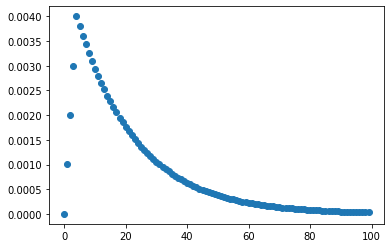

In [18]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE_TRAIN  
    print("lr_max", lr_max)
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.95
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [19]:
# callback to save weights
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_projection.h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True,
    save_weights_only=True, mode='max', save_freq='epoch')

# dataset
ds_train, train_len = get_projection_dataset_from_numpy( list_preproc_files_embeddings_train, list_preproc_files_labels_train, repeat=True, shuffle=True)
print( train_len )

ds_valid, valid_len = get_projection_dataset_from_numpy( list_preproc_files_embeddings_valid, list_preproc_files_labels_valid, repeat=False, shuffle=False)
print( valid_len )

# calc steps of dataset
steps_per_epoch = train_len // config.BATCH_SIZE_TRAIN
if train_len % config.BATCH_SIZE_TRAIN != 0:
    steps_per_epoch += 1

validation_steps = valid_len // config.BATCH_SIZE_TRAIN
if valid_len % config.BATCH_SIZE_TRAIN != 0:
    validation_steps += 1
    
print(steps_per_epoch, validation_steps)

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


./preproc//_label0_9690_train_embeddings.npy: embeddings.shape=(127756, 1280), labels.shape=(127756,) label=[0, 9690]
./preproc//_label9691_16690_train_embeddings.npy: embeddings.shape=(314265, 1280), labels.shape=(314265,) label=[9691, 16690]
./preproc//_label16691_22415_train_embeddings.npy: embeddings.shape=(346867, 1280), labels.shape=(346867,) label=[16691, 22415]
788888


  0%|          | 0/3 [00:00<?, ?it/s]

./preproc//_label0_9690_valid_embeddings.npy: embeddings.shape=(14196, 1280), labels.shape=(14196,) label=[0, 9688]
./preproc//_label9691_16690_valid_embeddings.npy: embeddings.shape=(34919, 1280), labels.shape=(34919,) label=[9691, 16690]
./preproc//_label16691_22415_valid_embeddings.npy: embeddings.shape=(38541, 1280), labels.shape=(38541,) label=[16691, 22415]
87656
987 110


In [20]:
# training projection model
if config.TRAIN:
    history = projection_model.fit(
        ds_train,
        epochs=config.EPOCHS,
        callbacks=[get_lr_callback(), sv_loss],
        steps_per_epoch=steps_per_epoch,
        validation_data = ds_valid,
        validation_steps = validation_steps,
        verbose=1
    )

lr_max 0.004
Epoch 1/100
987/987 [==============================] - ETA: 0s - loss: 10.3175 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.00000, saving model to ./clip-vit-large-patch14_224pix-emb64_projection.h5
987/987 [==============================] - 46s 38ms/step - loss: 10.3175 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 10.3175 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-06
Epoch 2/100
986/987 [============================>.] - ETA: 0s - loss: 4.2202 - sparse_categorical_accuracy: 0.3638 - sparse_top_k_categorical_accuracy: 0.5583
Epoch 2: val_sparse_categorical_accuracy improved from 0.00000 to 0.52001, saving model to ./clip-vit-large-patch14_224pix-emb64_projection.h5
987/987 [==============================] - 34s 35ms/step - loss: 4.2179 - spa

# Step3) save model weights

In [21]:
# load best weight 
projection_model.load_weights( config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_projection.h5" )

# save weight of entire model
model.save_weights(  config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_loss.h5" )

In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/kaggle/google_embedding')